# Final Project - Solar Panel Power Analysis

### Installing the Package PVLib

In [1]:
# conda install -c pvlib pvlib

In [2]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# The next line is to make the plots appear in the notebook
%matplotlib inline 

In [3]:
def obtain_panel_power_data(lat, lon, start, end, name, tilt, azimuth, panels, peakpower):
    """
    Determine the solarradiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param start: Startdate for data retrievel
    :param end: Endddate for data retrievel
    :param name: Name of the panel location on the object
    :param tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
    :param azimuth: Direction the panels, 0 is South, negative from south to east, positive from south to west
    :param panels: Number of panels on the location
    :param peakpower: Peakpower per panel
    :return:
    """
    if panels > 0:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=True, peakpower=peakpower*panels,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
    else:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=False,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
        poa['P'] = 0.0
    poa['date'] = pd.to_datetime(poa.index.date)
    poa['location'] = name
    poa['P'] = poa['P'].div(1000)    # change unit to kWh
    return poa

In [4]:
def get_data_for_location(lat, lon, panels,
                          startdate = pd.Timestamp('2005-01-01'), enddate = pd.Timestamp('2020-12-31')):
    """
    Determine the solar radiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param panels: panel locations
    :return: 
    """
    poas = {}
    poalist = []
    for panel in panels:
        poa = obtain_panel_power_data(lat, lon, startdate, enddate, 
                                      panel['name'], panel['tilt'], 
                                      panel['azimuth'], panel['nopanels'], panel['power'])
        poas[panel['name']] = poa
        poalist.append(poa)
                          
    dataset = pd.concat(poalist).sort_index()
    
    dataset = pd.merge(
        pvlib.solarposition.get_solarposition(dataset.index.unique(), lat, lon)[['zenith', 'elevation', 'azimuth']], 
        dataset,
        left_index=True, right_index=True).drop_duplicates()
    dataset = dataset.sort_values(['time', 'location'])
    dataset['month'] = dataset.index.month
    dataset['season'] = 1 + (dataset.month - 1) // 3
    return dataset

## Getting the Database

Configuration of the PV System

In [5]:
### PANEL CONFIGURATION
names    = ['front', 'back']  # PV configuration in relation to the Sun, front facing it and back with it's back facing it
tilts    = [35     , 35    ]  # PV Modules tilt Angle - In this analysis was defined as 35º
azimuths = [0     , 180   ]  # pvlib uses 0=North, 90=East, 180=South, 270=West as a convention, 
                              # To maximize the output the surface azimuth for the North Hemisphere should be 180(South)
nopanels = [5      , 10    ]
power    = [0.385  , 0.385 ]

panel_conf = []
for n, t, a, no, p in zip(names, tilts, azimuths, nopanels, power):
    panel_conf.append({"name": n, "tilt": t, "azimuth": a, "nopanels": no, 'power': p})

Making some assumptions: </br>
The PV modules considered will be FIXED and installed in roofs with 35º of TILT ANGLE. The Optimal tilt angle for Germany is 35-40º </br>
The analysis is for modules installed in the NORTH hemisphere. </br>
The azimuth considered will be 180º facing the TRUE SOUTH (back) and TRUE NORTH (front). </br>
The number of PV modules(panels) considered will be 5 for FRONT and 10 for BACK. </br>
The PV nominal power considered will be 385 Wp </br> 


In [6]:
#Obtaining the data for Berlin
lat = 52.5
lon = 13.4
df = get_data_for_location(lat, lon, panel_conf) # calling the function and obtaining the data for the given location.

# Exploring the dataset

In [7]:
df.head(5)

,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,date,location,month,season
time,,,,,,,,,,,,,,,
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.83,3.59,0,2005-01-01,back,1,1
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.83,3.59,0,2005-01-01,front,1,1
2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.76,3.45,0,2005-01-01,back,1,1
2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.76,3.45,0,2005-01-01,front,1,1
2005-01-01 02:11:00+00:00,134.776168,-44.776168,67.127870,0.0,0.0,0.0,0.0,0.0,6.77,3.31,0,2005-01-01,back,1,1


 A illustration showing the Solar angles with it's name

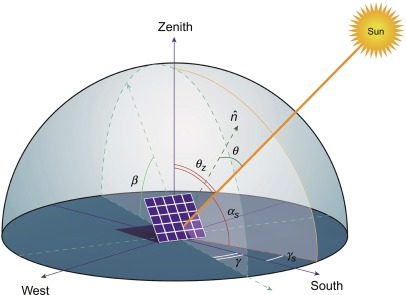

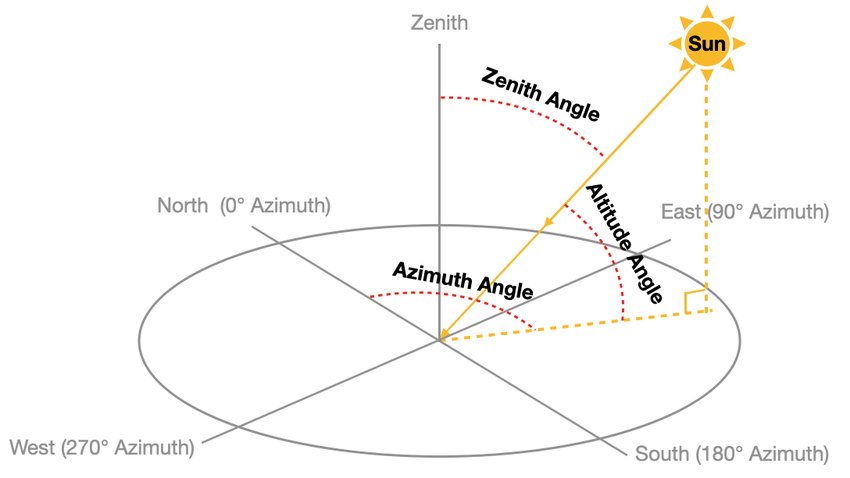

In [8]:
df.describe(include= "all").round(2)

C:\Users\icaro\AppData\Local\Temp\ipykernel_3652\2540686455.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include= "all").round(2)


,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,date,location,month,season
count,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.0,280512,280512,280512.00,280512.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5844,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-01 00:00:00,back,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,140256,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31 00:00:00,NaN,NaN,NaN
mean,89.67,0.33,178.81,0.27,55.38,59.24,2.22,12.45,10.43,2.97,0.0,NaN,NaN,6.52,2.51
std,29.69,29.69,102.37,0.45,142.29,87.72,3.71,17.09,8.26,1.37,0.0,NaN,NaN,3.45,1.12
min,29.07,-60.92,0.00,0.00,0.00,0.00,0.00,-0.60,-22.16,0.00,0.0,NaN,NaN,1.00,1.00
25%,67.91,-21.07,88.71,0.00,0.00,0.00,0.00,0.00,4.23,2.00,0.0,NaN,NaN,4.00,2.00


Observing if the dataset has missing values

In [9]:
df.isna().sum()

zenith                0
elevation             0
azimuth               0
P                     0
poa_direct            0
poa_sky_diffuse       0
poa_ground_diffuse    0
solar_elevation       0
temp_air              0
wind_speed            0
Int                   0
date                  0
location              0
month                 0
season                0
dtype: int64

In [10]:
df.dtypes

zenith                       float64
elevation                    float64
azimuth                      float64
P                            float64
poa_direct                   float64
poa_sky_diffuse              float64
poa_ground_diffuse           float64
solar_elevation              float64
temp_air                     float64
wind_speed                   float64
Int                            int32
date                  datetime64[ns]
location                      object
month                          int64
season                         int64
dtype: object

Observing the results of the describe function the variable INT have all values equal to 0, so it is going to be removed from the analysis

In [11]:
df.drop(columns ="Int", inplace=True)
df.head(2)

,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,date,location,month,season
time,,,,,,,,,,,,,,
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.83,3.59,2005-01-01,back,1,1
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.83,3.59,2005-01-01,front,1,1


Exploring the variables for an Outlier

In [12]:
import numpy as np
import seaborn as sns 
sns.set() 

To use seaborn we need a unique index, so using reset_index function

In [13]:
df.reset_index(inplace=True)

In [14]:
'''
plt.figure(figsize = (16,8))
ax = sns.histplot(data=df[df !=0], x='P', kde=True, bins= 100) #Ignoring the values that are equal to 0
ax.set_title("Power Values (KWh)", fontsize=18)
ax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")
plt.ylim((0,4500))
plt.xlim((0.12, 2))
x_ticks = np.arange(0.1, 2.0, 0.25)
#plt.xticks(x_ticks, rotation=45)
#plt.ticklabel_format(style='plain', axis='x') 
ax = ax
plt.show
'''

'\nplt.figure(figsize = (16,8))\nax = sns.histplot(data=df[df !=0], x=\'P\', kde=True, bins= 100) #Ignoring the values that are equal to 0\nax.set_title("Power Values (KWh)", fontsize=18)\nax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")\nplt.ylim((0,4500))\nplt.xlim((0.12, 2))\nx_ticks = np.arange(0.1, 2.0, 0.25)\n#plt.xticks(x_ticks, rotation=45)\n#plt.ticklabel_format(style=\'plain\', axis=\'x\') \nax = ax\nplt.show\n'

### Automatizing the plotting

'\nplt.figure(figsize = (16,8))\nax = sns.histplot(data=df[column !=0], x=df[column], kde=True, bins= 100) #Ignoring the values that are equal to 0\n#ax.set_title("Power Values (KWh)", fontsize=18)\n#ax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")\n#plt.ylim((0,4500))\n#plt.xlim((0.12, 2))\n#x_ticks = np.arange(0.1, 2.0, 0.25)\n#plt.xticks(x_ticks, rotation=45)\n#plt.ticklabel_format(style=\'plain\', axis=\'x\') \nax = ax\nplt.show\n'

<Figure size 640x480 with 0 Axes>

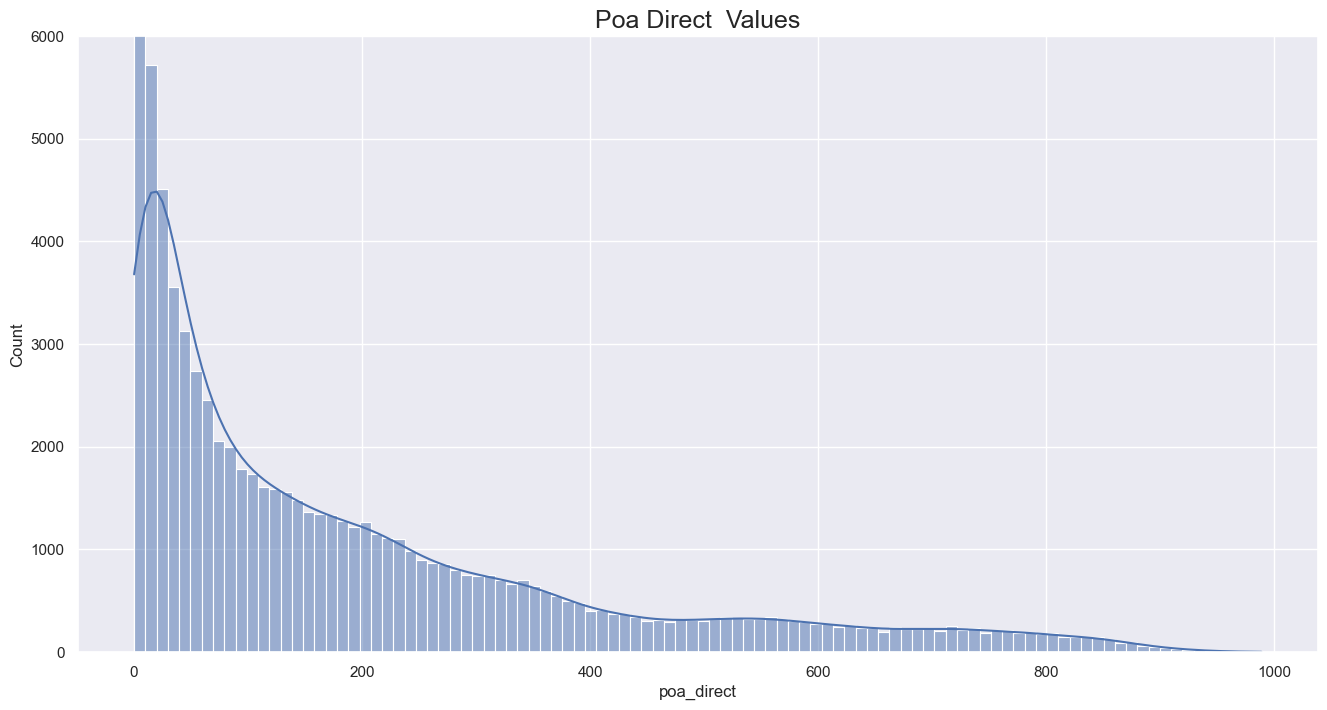

<Figure size 640x480 with 0 Axes>

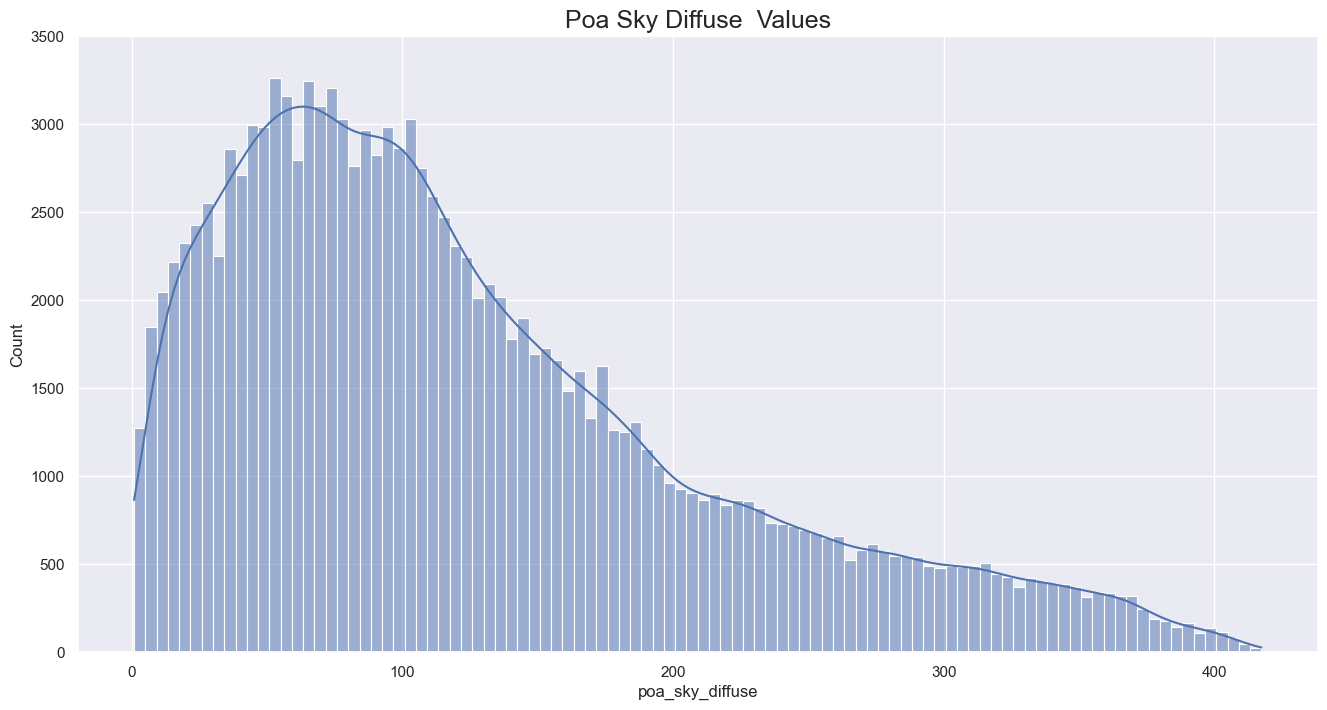

<Figure size 640x480 with 0 Axes>

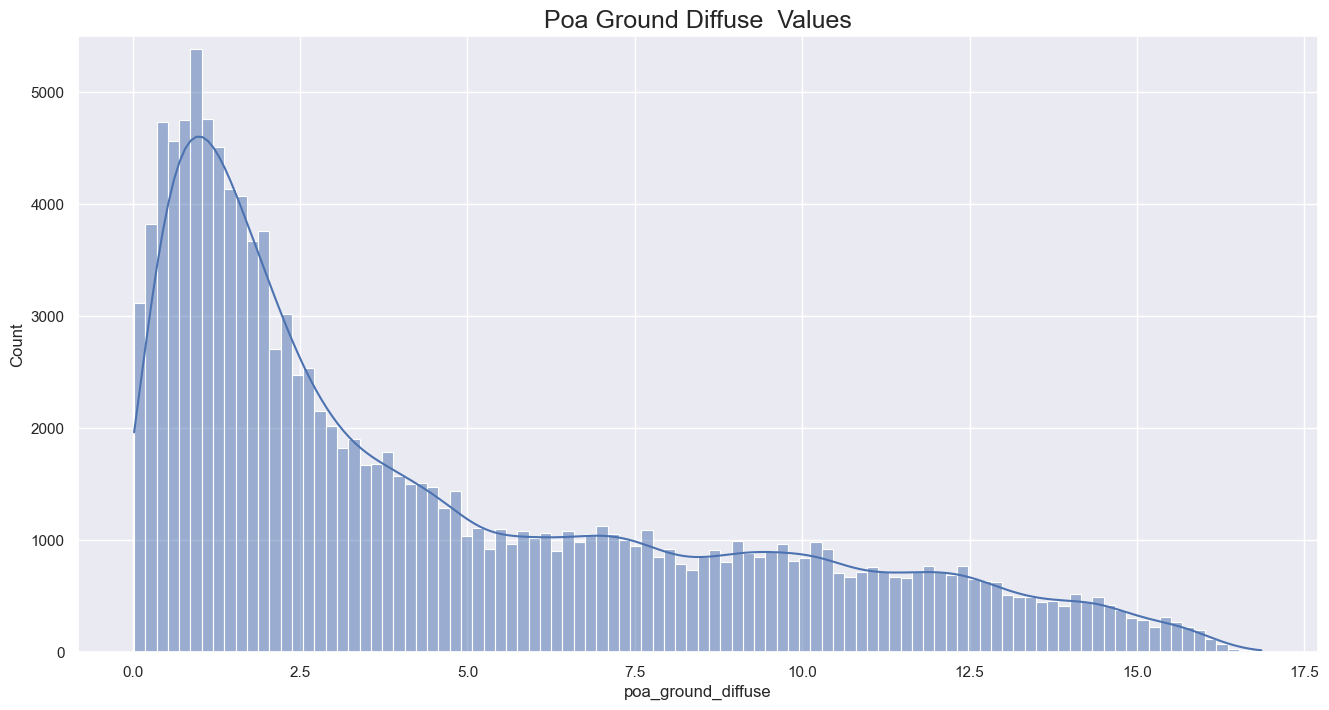

<Figure size 640x480 with 0 Axes>

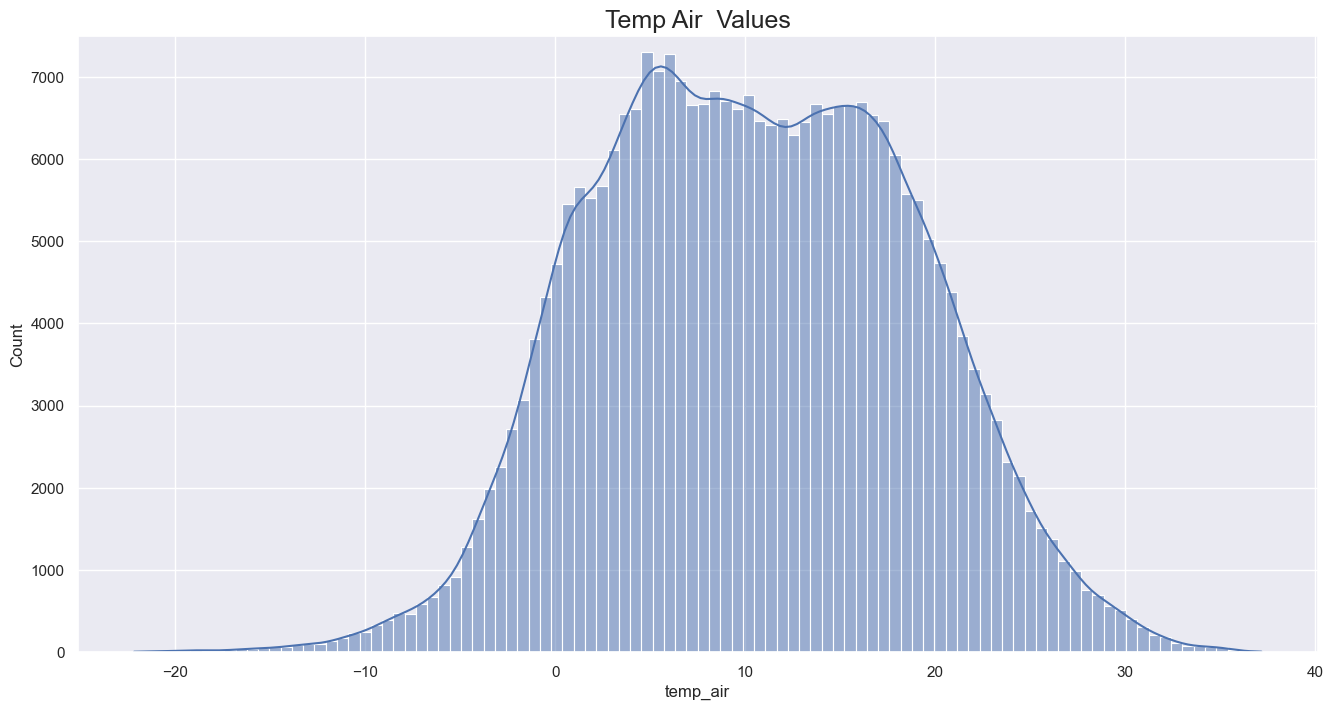

<Figure size 640x480 with 0 Axes>

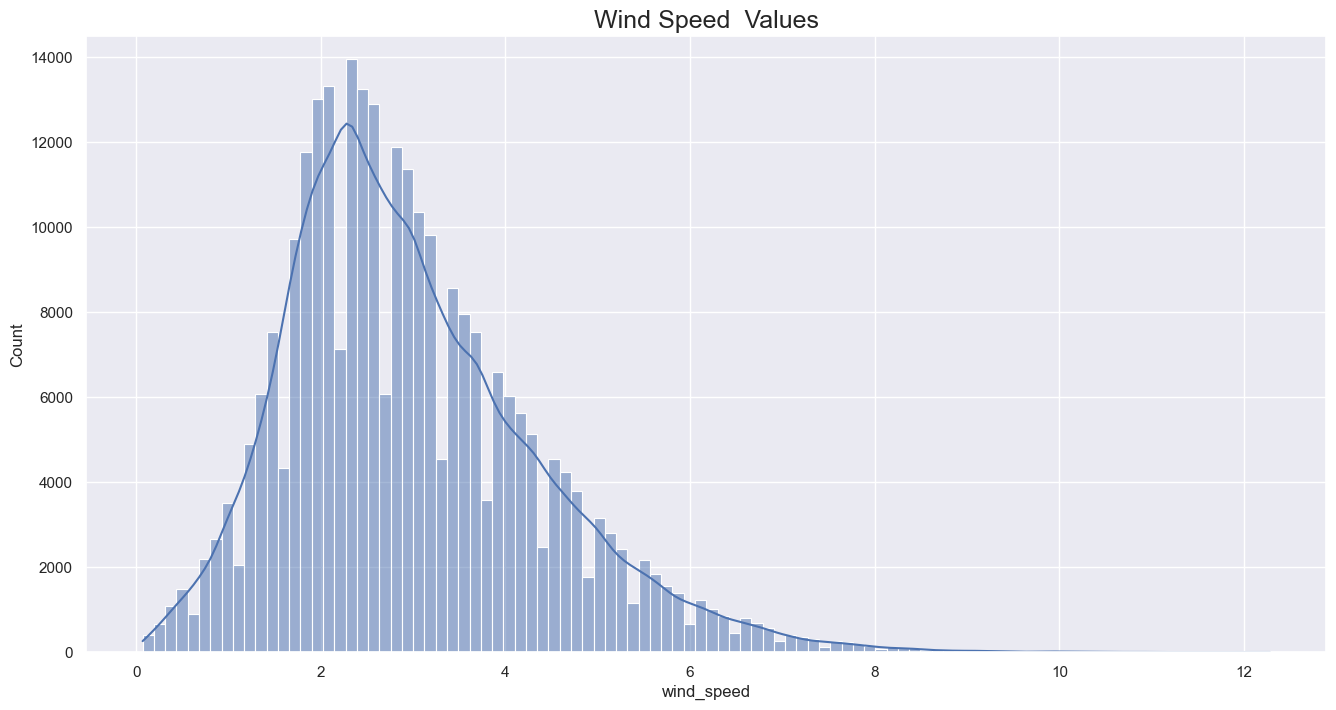

In [15]:
column_plot =["poa_direct","poa_sky_diffuse", "poa_ground_diffuse","temp_air","wind_speed"]
for column in column_plot:
    plt.figure()
    plt.figure(figsize = (16,8))
    ax = sns.histplot(data=df[df !=0], x=column, kde=True, bins= 100) #Ignoring the values that are equal to 0
    splitcolumn = column.split("_")
    title = ""
    for name in splitcolumn:
        x_title = name.title()
        title += x_title + " " 
    ax.set_title(title + " Values", fontsize=18)
    title = ""
    if column == "poa_direct":
        LowerLimit = 0
        UpperLimit = 6000
    elif column == "poa_sky_diffuse": 
        LowerLimit = 0
        UpperLimit = 3500
    elif column == "poa_ground_diffuse": 
        LowerLimit = 0
        UpperLimit = 5500
    elif column == "temp_air": 
        LowerLimit = 0
        UpperLimit = 7500
    elif column == "wind_speed": 
        LowerLimit = 0
        UpperLimit = 14500    
    plt.ylim((LowerLimit,UpperLimit))
    
    ax = ax
    plt.show
'''
plt.figure(figsize = (16,8))
ax = sns.histplot(data=df[column !=0], x=df[column], kde=True, bins= 100) #Ignoring the values that are equal to 0
#ax.set_title("Power Values (KWh)", fontsize=18)
#ax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")
#plt.ylim((0,4500))
#plt.xlim((0.12, 2))
#x_ticks = np.arange(0.1, 2.0, 0.25)
#plt.xticks(x_ticks, rotation=45)
#plt.ticklabel_format(style='plain', axis='x') 
ax = ax
plt.show
'''

## Correlation

In [16]:
# Defining the function to plot the correlation
def corr_graph(df):
    plt.figure(figsize=(20,10))
    mask = np.triu(np.ones_like(df.corr(), dtype=bool)) 
    heatmap = sns.heatmap(df.corr(),mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG", fmt='.2f')
    heatmap.set_title("Correlation", fontdict={"fontsize":18}, pad=16)
    plt.show
    return(heatmap)

<AxesSubplot:title={'center':'Correlation'}>

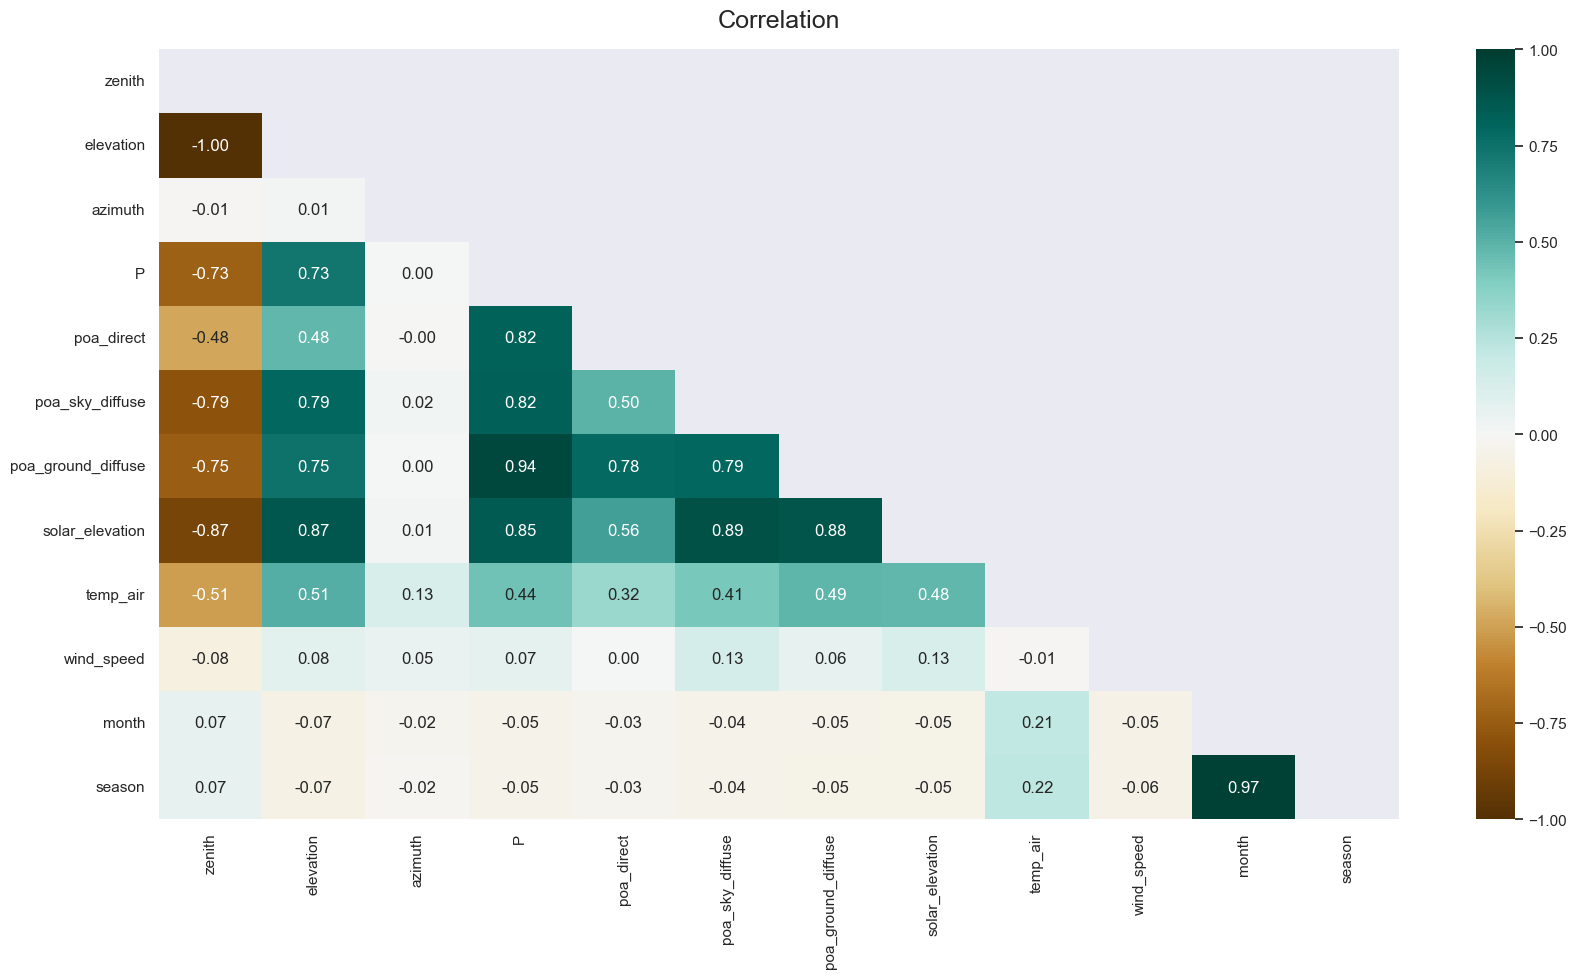

In [17]:
#calling the function
corr_graph(df)

Observing the predictors the poa (direct, sky diffuse, ground diffuse) have a very high correlation. That makes sense since they are all part of the solar beam. And zenith and solar elevation also have a high correlation 

# Making the first Interaction with ML

The P column is the variable I want to predict. Power in KWh

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

y= df["P"]
X = df
X = df.drop(columns="P")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1990)

In [19]:
# import
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

#Setting the imputers, Scaler 
imputer = KNNImputer()
scaler = StandardScaler()

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

In [20]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns),
    ]
)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
full_pipeline = make_pipeline(preprocessor, 
                              LinearRegression())

param_grid = {
    "columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    "columntransformer__num_pipe__standardscaler__with_std":[True, False], 
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
       
}


search = RandomizedSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)
print("Fitting Done")

C:\Users\icaro\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting Done


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics          

In [23]:
# defining the score printing function for TRAIN data
def linear_train_score(X_train, y_train):
    score = search.score(X_train, y_train)
    return print("Linear Train R² score = {}".format(score.round(3)))

In [24]:
linear_train_score(X_train,y_train)

Linear Train R² score = 0.969


Why so High???? Maybe it is overfitting

In [25]:
# defining the score printing function for TEST  data
def linear_test_score(X_test):
    y_previsto = search.predict(X_test)
    return print("Linear Test R² score = %s" %metrics.r2_score(y_test, y_previsto).round(3))

In [26]:
linear_test_score(X_test)

Linear Test R² score = 0.775


### Creating a function to plot the predicted  Power values 

In [27]:
# Defining a function to plot the predicted values
def Pred_graph(Y_search):
    plt.figure(figsize = (16,8))
    ax = sns.histplot(data=Y_search, x=Y_search[0], kde=True, bins= 100) #Ignoring the values that are equal to 0
    ax.set_title("Predicted Power Values (KWh)", fontsize=18)
    ax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")
    plt.ylim((0,4500))
    plt.xlim((0.12, 2))
    x_ticks = np.arange(0.1, 2.0, 0.25)
    ax = ax
    plt.show
    return ax

In [30]:
y_previsto = search.predict(X_test)
y_previsto = pd.DataFrame(data=y_previsto)
y_previsto.reset_index()
Pred_graph(y_previsto)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1600x800 with 0 Axes>

# Interaction 2 - Removing some predictors with high correlation between themselves 

In [ ]:
corr_graph(df)

Dropping the variables poa (sky diffuse, ground diffuse)

In [ ]:
df.drop(columns=["poa_sky_diffuse", "poa_ground_diffuse"], inplace=True)

In [ ]:
corr_graph(df)

Running the model again

In [ ]:
y= df["P"]
X = df
X = df.drop(columns="P")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1990)
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

#Setting the imputers, Scaler 
imputer = KNNImputer()
scaler = StandardScaler()

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     
 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns),
    ]
)

full_pipeline = make_pipeline(preprocessor, 
                              LinearRegression())

param_grid = {
    "columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    "columntransformer__num_pipe__standardscaler__with_std":[True, False], 
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
       
}


search = RandomizedSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

In [ ]:
linear_train_score(X_train,y_train)
linear_test_score(X_test)

The score for training data is the same


In [ ]:
Pred_graph(Y_search)

### Running interaction 3 

The variable elevation and solar_elevation have a high correlation between themselfs and I belive they express the same information but taken from different reference points. </br>
The same is valid for months and season.

In [ ]:
df.drop(columns=["elevation", "month"], inplace=True)

Making the correlation graph again to observe the changes.

In [ ]:
corr_graph(df)

In [ ]:
y= df["P"]
X = df
X = df.drop(columns="P")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1990)
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

#Setting the imputers, Scaler 
imputer = KNNImputer()
scaler = StandardScaler()

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     
 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns),
    ]
)

full_pipeline = make_pipeline(preprocessor, 
                              LinearRegression())

param_grid = {
    "columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    "columntransformer__num_pipe__standardscaler__with_std":[True, False], 
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
       
}


search = RandomizedSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search.fit(X_train, y_train)

In [ ]:
linear_train_score(X_train,y_train)
linear_test_score(X_test)

In [ ]:
#Plotting the predited values graph
Pred_graph(Y_search)